In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
# from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

# load the file

In [ ]:
X_train=np.load('/content/drive/MyDrive/deep_learning_project/X_train.npy')
X_test=np.load('/content/drive/MyDrive/deep_learning_project/X_test.npy')
y_train=np.load('/content/drive/MyDrive/deep_learning_project/y_train.npy')
y_test=np.load('/content/drive/MyDrive/deep_learning_project/y_test.npy')

# load pretrained network

In [ ]:
from keras.layers import Input
from keras.applications.vgg16 import VGG16, preprocess_input

vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)


x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(vgg16_input,x)
vgg16_pretrained.summary()

sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


# train the model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
import time

img_rows, img_cols = 64, 64
batch_size = 32
nb_epoch = 100

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)


vgg16_model = vgg16_pretrained.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch
                ,verbose=1, validation_data=(X_test, y_test),callbacks=[callback,time_callback])



Epoch 1/100
540/540 [==============================] - 138s 218ms/step - loss: 2.0154 - accuracy: 0.3941 - val_loss: 1.5244 - val_accuracy: 0.6359
Epoch 2/100
540/540 [==============================] - 114s 211ms/step - loss: 0.0704 - accuracy: 0.9822 - val_loss: 1.2627 - val_accuracy: 0.6838
Epoch 3/100
540/540 [==============================] - 114s 211ms/step - loss: 0.0158 - accuracy: 0.9956 - val_loss: 1.5540 - val_accuracy: 0.6456
Epoch 4/100
540/540 [==============================] - 114s 211ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 1.4902 - val_accuracy: 0.6676
Epoch 5/100
540/540 [==============================] - 114s 211ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 1.5652 - val_accuracy: 0.6935
Epoch 6/100
540/540 [==============================] - 114s 211ms/step - loss: 2.9901e-04 - accuracy: 1.0000 - val_loss: 1.5802 - val_accuracy: 0.6958
Epoch 7/100
540/540 [==============================] - 114s 211ms/step - loss: 1.7766e-04 - accuracy: 1.0000 - val

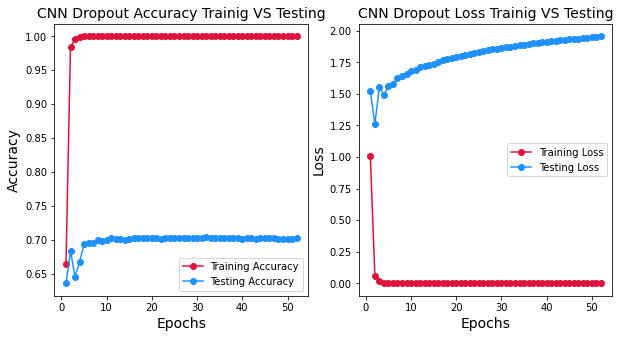

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy']) + 1), vgg16_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy']) + 1), vgg16_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

# save result

In [ ]:
vgg_no_augment = pd.DataFrame(vgg16_model.history)
vgg_no_augment['time'] = time_callback.times
vgg_no_augment.to_csv('vgg_no_augment.csv')